<font size=7> Latencies Analysis

In [1]:
import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, plot_latency_dist_hist, plot_latency_angle_hist, \
                                 plot_cross_sttc_pairs #, plot_vector_layout2, plot_vector_layout3
from human_hip.animate import animate_latencies
import human_hip.spike_data as spike_data

In [2]:
sd = spike_data.read_autocurated_data( "/workspaces/human_hippocampus/data/ephys/2023-12-11-e-Hc120523_aav9hckcr1_chip21769/derived/kilosort2/Hc120523_aav9hckcr1_chip21769_121123_2_acqm.zip" )


In [3]:
# good_pairs = curate_latencies(sd)
# with open( 'curate_latencies_good_pairs.pkl' , 'wb') as my_file:
#    pickle.dump(good_pairs, my_file)
#load pickled data
with open( 'curate_latencies_good_pairs.pkl' , 'rb') as my_file:
    good_pairs = pickle.load(my_file)
print(len(good_pairs))

71


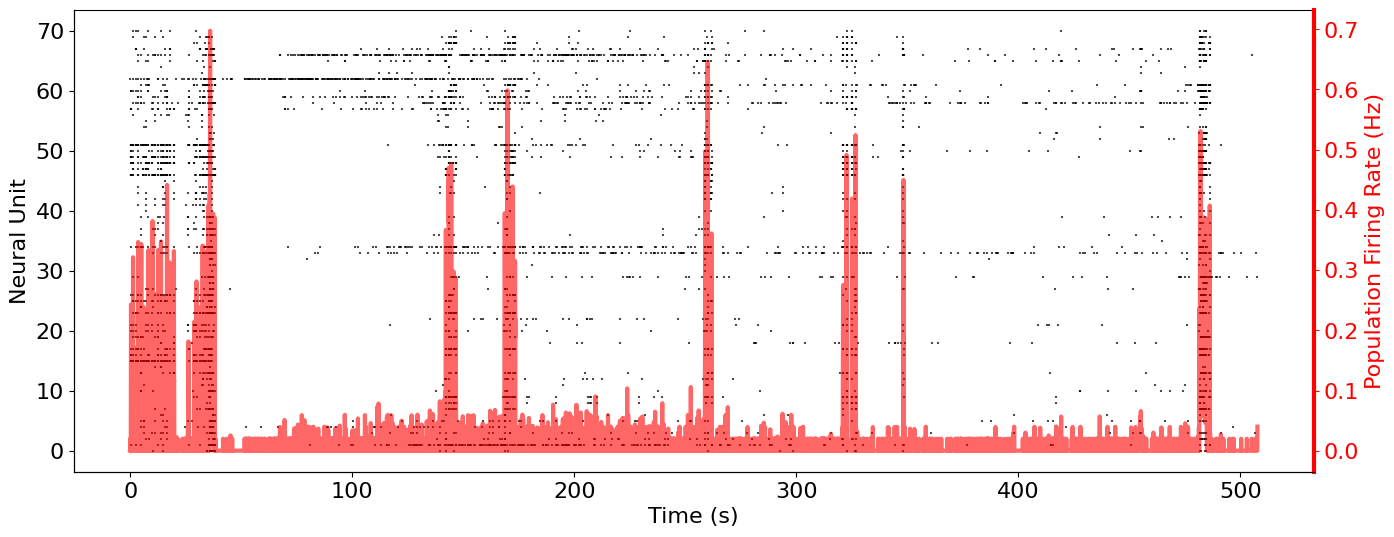

In [4]:
plot_raster_latency_pairs( sd, good_pairs )

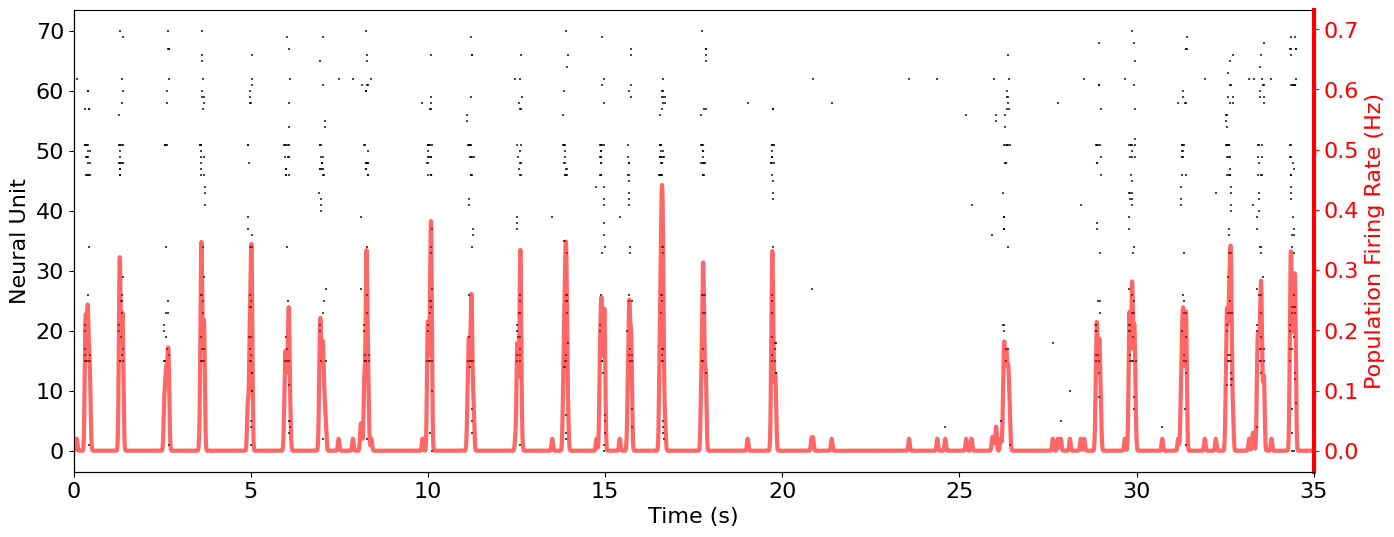

In [5]:
plot_raster_latency_pairs( sd, good_pairs, xlim=(0,35) )

399 um -- average pair distance
364 um -- average latency distance


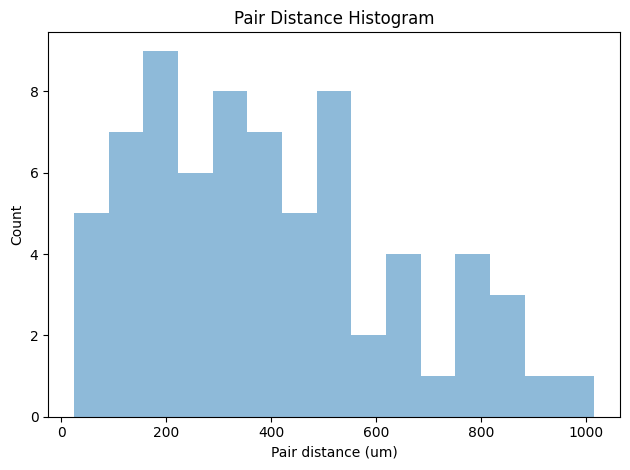

In [6]:
plot_latency_dist_hist(sd, good_pairs)

In [3]:
plot_latency_angle_hist( sd, good_pairs)

NameError: name 'sd' is not defined

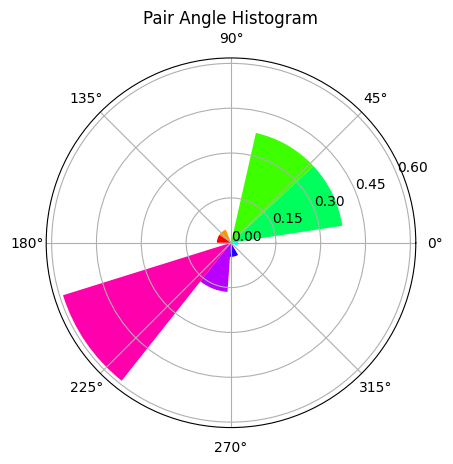

In [11]:
plot_latency_angle_hist( sd, good_pairs)

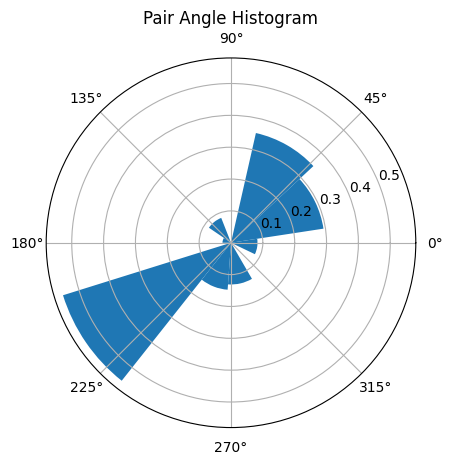

In [8]:
plot_latency_angle_hist( sd, good_pairs, by_firing_rate=True)

# <font color="brown">Figure Plot

In [9]:
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrow
from sklearn import preprocessing
import numpy as np
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint, cross_sttc
from braingeneers.analysis.analysis import SpikeData
import warnings
import diptest 
import math
import matplotlib.cm as cm
from ipywidgets import interact_manual
from matplotlib.ticker import MaxNLocator
import numpy as np


In [28]:

def plot_vector_layout2( sd, pairs, image_path=None, figsize=(8, 8), xlim=None, ylim=None, ms_cutoff_high=20 ):

    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # organize pair directions
    pairs = pairs                         # make a copy of pairs, this avoids some bug
    for i in range(len(pairs)):
        lag = np.median(latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=ms_cutoff_high))
        if lag<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]

    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

    # clump by starting pair angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key].append( angles[i] )
        else:
            pair_dict[key] = [ angles[i] ]

    # create new dictionary of just mean angles
    for key, value in pair_dict.items():
        pair_dict[key] = sum(value) / len(value)


    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    for pair, angle in pair_dict.items():
        angle2 = (angle*-1+ np.pi)/np.pi/2
        #angle2 = (angle2 + .5) % 1

        start = neuron_xy[ pair ]  
        arrow = FancyArrow( 
                start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
        plt.gca().add_patch(arrow)

In [7]:
def plot_vector_layout3( sd, pairs, image_path=None, figsize=(8, 8), xlim=None, ylim=None, ms_cutoff_high=20 ):

    # Get the x/y locations of the start and end neurons of each pair
    neuron_xy = []
    for neuron in sd.neuron_data[0].values():
        neuron_xy.append( [neuron['position'][0], neuron['position'][1]] )
    neuron_xy = np.array(neuron_xy)

    # Latencies count
    pairs = good_pairs                      # make a copy of pairs, this avoids some bug
    latencies_count = []
    for i in range(len(pairs)):
        pair_latencies = latencies( pairs[i][0], pairs[i][1], sd, ms_cutoff_high=20)
        latencies_count.append(len(pair_latencies))
        if np.median(pair_latencies)<0:
            pairs[i] = [ pairs[i][1], pairs[i][0] ]

    starts = neuron_xy[ pairs[:,0] ]  # Get the x/y locations of the start and end neurons of each pair
    ends = neuron_xy[ pairs[:,1] ]
    centered = ends-starts   # Get the directions of arrows, then make of of them the same length
    normalized = preprocessing.normalize(centered) #* 75
    angles = np.arctan2( normalized[:, 1], normalized[:, 0] ) 

    # clump by starting pair angle counted by angle
    pair_dict = {}
    for i in range(len(pairs)):
        key, value = pairs[i]
        if key in pair_dict:
            pair_dict[key] = pair_dict[key] + [ angles[i] ] * latencies_count[i]
        else:
            pair_dict[key] = [ angles[i] ] * latencies_count[i]

    # create new dictionary of just mean angles
    for key, value in pair_dict.items():
        pair_dict[key] = sum(value) / len(value)


    # Plot original scatter
    plt.figure(figsize=(8, 8))
    ax = plt.axes()
    if image_path is not None:
        img = plt.imread(image_path)      # Load in image
        plt.imshow(img,  extent=[0, 3850, 0, 2100]) 
    plt.xlim( xlim )
    plt.ylim( ylim )    

    # Draw Arrows
    cmap = cm.get_cmap('hsv')
    for pair, angle in pair_dict.items():
        angle2 = (angle*-1+ np.pi)/np.pi/2

        start = neuron_xy[ pair ]  
        arrow = FancyArrow( 
                start[0], start[1], np.cos(angle)*75 , np.sin(angle)*75, length_includes_head=True, head_width=25,
                linewidth=1, color=cmap(angle2,alpha=0.9)  ) #color="red"
        plt.gca().add_patch(arrow)

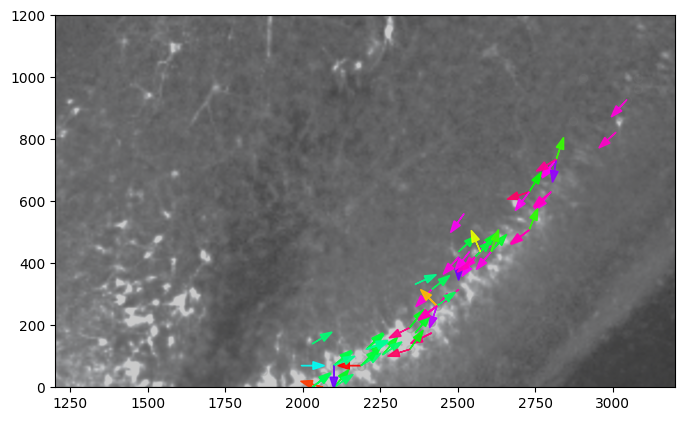

In [22]:
plot_vector_layout( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                   xlim=(1200,3200), ylim=(0,1200) )

/tmp/ipykernel_11168/3376290751.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():


/tmp/ipykernel_11168/3376290751.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


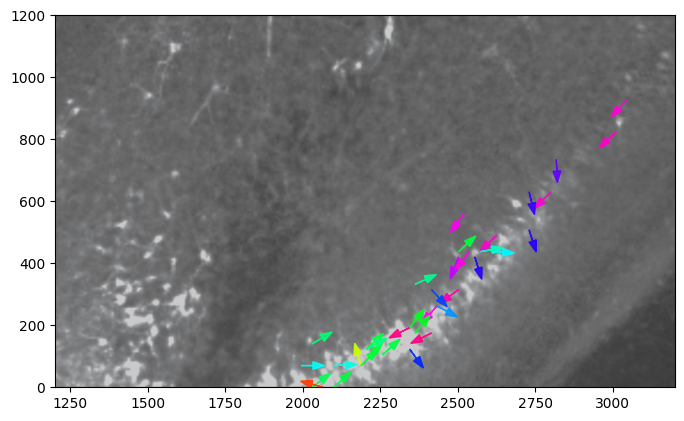

In [29]:
plot_vector_layout2( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                   xlim=(1200,3200), ylim=(0,1200) )

/tmp/ipykernel_2209/3919229163.py:5: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  for neuron in sd.neuron_data[0].values():
/tmp/ipykernel_2209/3919229163.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('hsv')


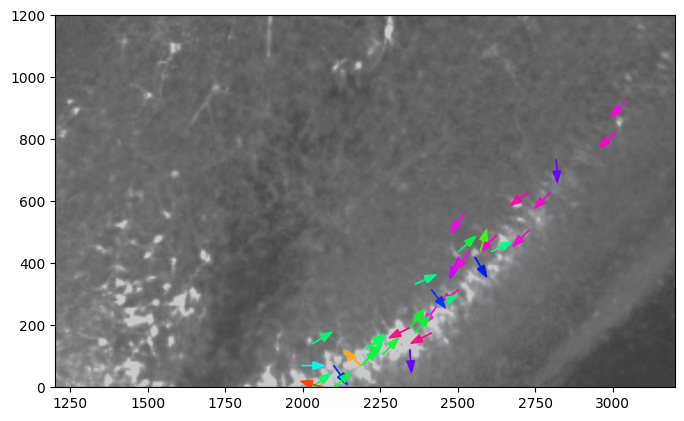

In [10]:
plot_vector_layout3( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                   xlim=(1200,3200), ylim=(0,1200) )

# Vector Plots

In [5]:
plot_vector_layout

<function human_hip.spike_data.plot_latencies.plot_vector_layout(sd, pairs, normalize=True, plot_neuron=True, arrow_length=75, min_dist=0, image_path=None, xlim=None, ylim=None, background_color='white')>

In [7]:
plot_vector_layout( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                   xlim=(1200,3200), ylim=(0,1200) )

NameError: name 'sd' is not defined

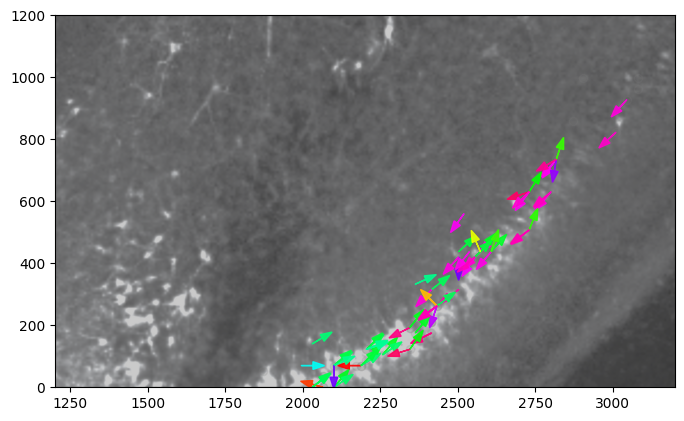

In [7]:
plot_vector_layout( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                   xlim=(1200,3200), ylim=(0,1200) )

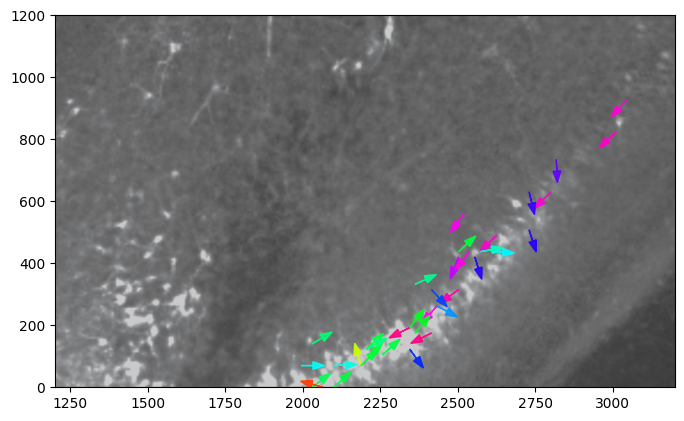

In [7]:
plot_vector_layout2( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                   xlim=(1200,3200), ylim=(0,1200) )

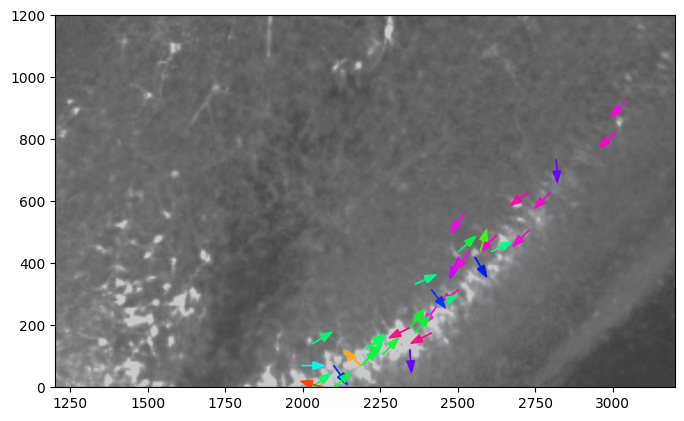

In [4]:
plot_vector_layout3( sd, good_pairs, image_path="/workspaces/human_hippocampus/data/histology/chip21769_bw2.png",
                   xlim=(1200,3200), ylim=(0,1200) )

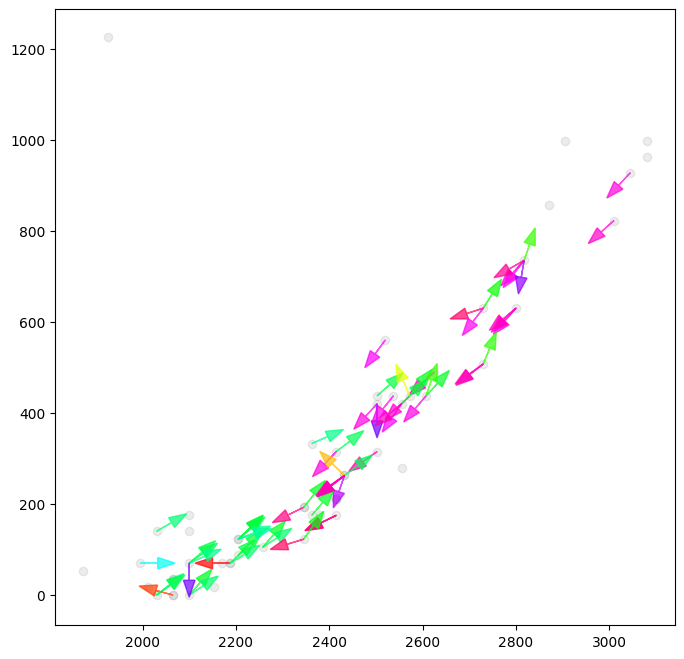

In [12]:
plot_vector_layout( sd, good_pairs)

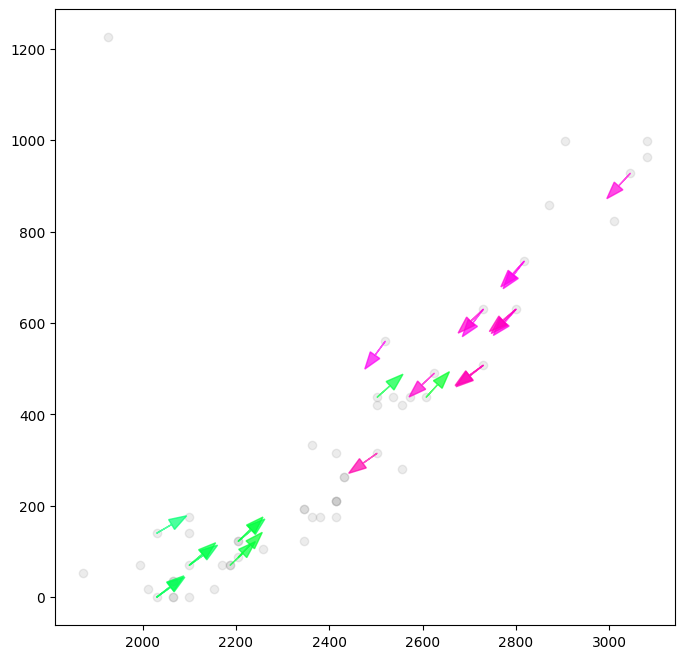

In [13]:
plot_vector_layout( sd, good_pairs, min_dist=500 )

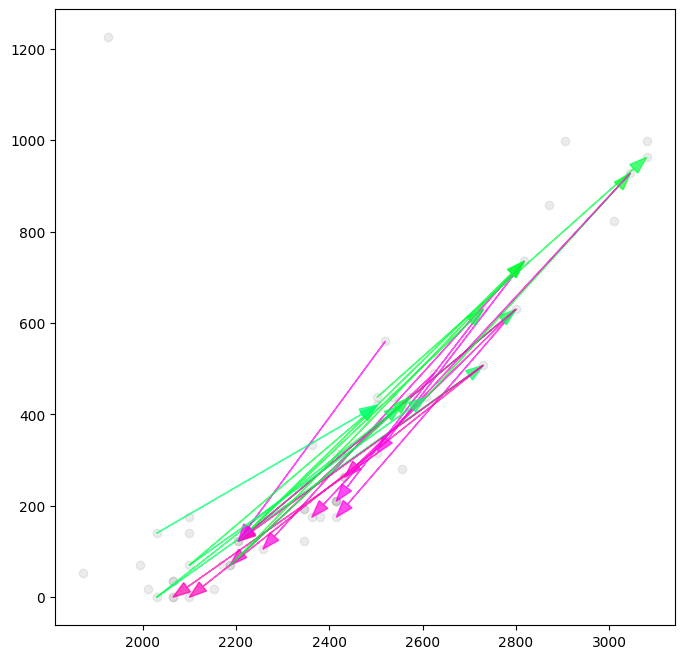

In [14]:
plot_vector_layout( sd, good_pairs, min_dist=500, normalize=False )

# <font color="red">Make Animations - NOT DONE

In [15]:
animate_latencies(plot_vector=True, ms_range=range(0,1000) )

<function human_hip.animate.animate_latency_pairs.animate_latencies(sd, pairs, movie_range_ms=None, frame_interval_ms=500, directed=True, directed_backwards=False, filename='latencies.mp4', latency_ms_cutoff_low=1, latency_ms_cutoff_high=15, plot_vector=False, min_dist=0)>

25781 latency events occured in total spikedata
Making animation of 3.008 minutes
Saved animation to media/latencies.mp4


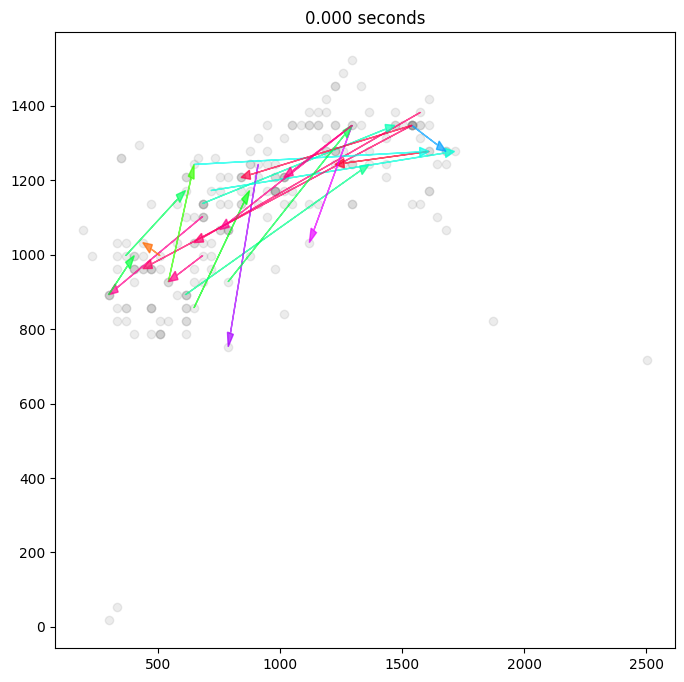

In [14]:
animate_latencies(sd, good_pairs, filename="media/latencies.mp4" )

1860 latency events occured in total spikedata
668 latency events occured above 500 um distance
Making animation of 2.283 minutes
Saved animation to media/latencies_mindist500.mp4


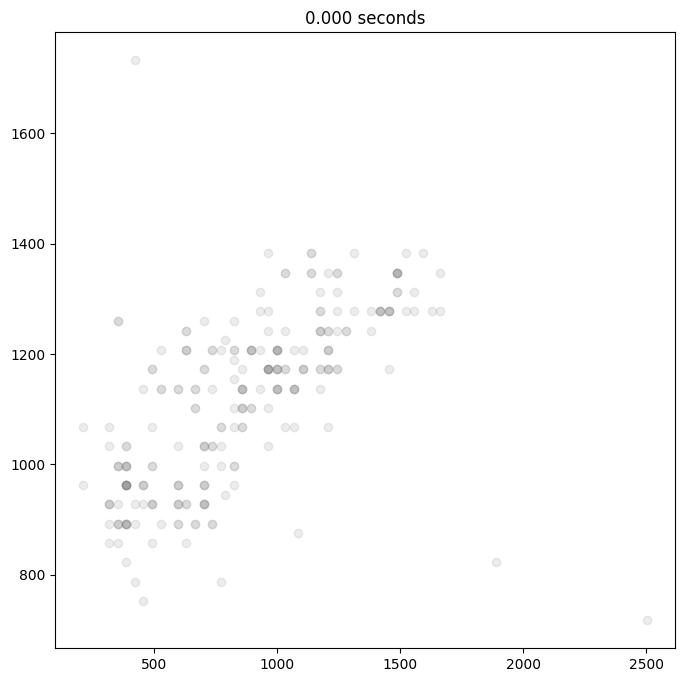

In [13]:
animate_latencies(sd, good_pairs,  filename='media/latencies_mindist500.mp4', min_dist=500 )

In [ ]:
# animate_latencies(sd, pairs, movie_range_ms=None, frame_interval_ms=500, directed=True, filename="latencies.mp4",
#                       latency_ms_cutoff_low=0, latency_ms_cutoff_high=15 ):